# Early Stopping for PyTorch

本文主要参考：[Early Stopping for PyTorch](https://github.com/Bjarten/early-stopping-pytorch)。

早停法是一种正则化形式，用于避免过度拟合训练数据集。跟踪验证损失以尽早停止，如果连续几个epoch损失停止减少，则训练将停止。pytorchtool.py中的EarlyStopping类用于创建对象，以在训练PyTorch模型时跟踪验证loss。每当验证损失减少时，它将保存模型的检查点。我们将类中的patience参数设置为在EarlyStopping上次验证损失改善后要中断训练循环之前要等待多少个时期。EarlyStopping在MNIST_Early_Stopping_example笔记本中有一个简单的示例，说明如何使用该类。接下来一个例子，是在MNIST数据集上用NN来做早停法。

In [1]:
# import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt

接下来加载和batch数据

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

def create_datasets(batch_size):

    # percentage of training set to use as validation
    valid_size = 0.2

    # convert data to torch.FloatTensor
    transform = transforms.ToTensor()

    # choose the training and test datasets
    train_data = datasets.MNIST(root='data', 
                                train=True,
                                download=True, 
                                transform=transform)

    test_data = datasets.MNIST(root='data',
                               train=False,
                               download=True,
                               transform=transform)

    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # load training data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=0)
    
    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0)
    
    # load test data in batches
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              num_workers=0)
    
    return train_loader, test_loader, valid_loader

定义网络

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [4]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.Adam(model.parameters())

In [5]:
# import EarlyStopping
from pytorchtools import EarlyStopping

In [6]:
def train_model(model, batch_size, patience, n_epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

In [11]:
batch_size = 256
n_epochs = 100

train_loader, test_loader, valid_loader = create_datasets(batch_size)

Using downloaded and verified file: data\MNIST\raw\train-images-idx3-ubyte.gz
Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw
Using downloaded and verified file: data\MNIST\raw\train-labels-idx1-ubyte.gz
Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw
Using downloaded and verified file: data\MNIST\raw\t10k-images-idx3-ubyte.gz
Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw
Using downloaded and verified file: data\MNIST\raw\t10k-labels-idx1-ubyte.gz
Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw
Processing...
Done!


In [12]:
# early stopping patience; how long to wait after last time validation loss improved.
patience = 20

model, train_loss, valid_loss = train_model(model, batch_size, patience, n_epochs)

[  1/100] train_loss: 0.83646 valid_loss: 0.30541
Validation loss decreased (inf --> 0.305412).  Saving model ...
[  2/100] train_loss: 0.37217 valid_loss: 0.22631
Validation loss decreased (0.305412 --> 0.226307).  Saving model ...
[  3/100] train_loss: 0.29700 valid_loss: 0.18568
Validation loss decreased (0.226307 --> 0.185680).  Saving model ...
[  4/100] train_loss: 0.25424 valid_loss: 0.16183
Validation loss decreased (0.185680 --> 0.161832).  Saving model ...
[  5/100] train_loss: 0.23119 valid_loss: 0.14917
Validation loss decreased (0.161832 --> 0.149171).  Saving model ...
[  6/100] train_loss: 0.21292 valid_loss: 0.14260
Validation loss decreased (0.149171 --> 0.142605).  Saving model ...
[  7/100] train_loss: 0.19666 valid_loss: 0.13002
Validation loss decreased (0.142605 --> 0.130023).  Saving model ...
[  8/100] train_loss: 0.18337 valid_loss: 0.12157
Validation loss decreased (0.130023 --> 0.121573).  Saving model ...
[  9/100] train_loss: 0.17235 valid_loss: 0.11491
Val

然后可视化下训练过程来看看。

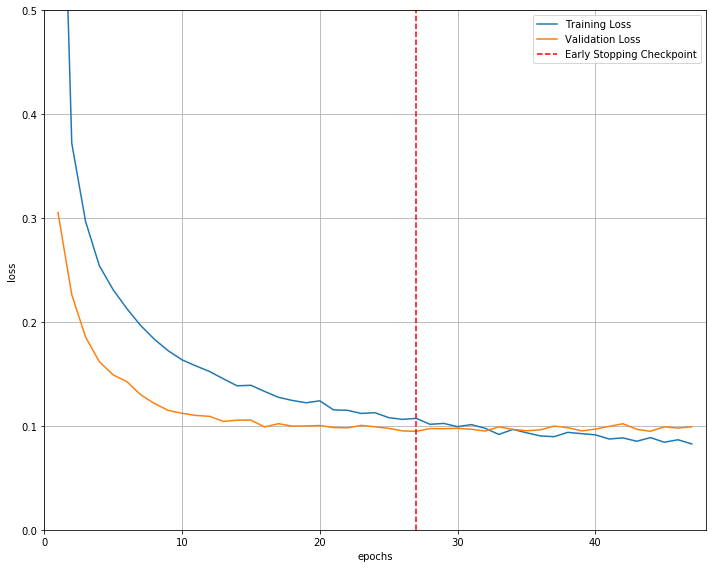

In [13]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

最后是测试：

In [14]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    if len(target.data) != batch_size:
        break
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.087527

Test Accuracy of     0: 98% (967/979)
Test Accuracy of     1: 98% (1119/1133)
Test Accuracy of     2: 97% (1004/1030)
Test Accuracy of     3: 97% (987/1008)
Test Accuracy of     4: 98% (962/980)
Test Accuracy of     5: 96% (860/890)
Test Accuracy of     6: 97% (935/956)
Test Accuracy of     7: 97% (1001/1027)
Test Accuracy of     8: 96% (936/973)
Test Accuracy of     9: 95% (965/1008)

Test Accuracy (Overall): 97% (9736/9984)


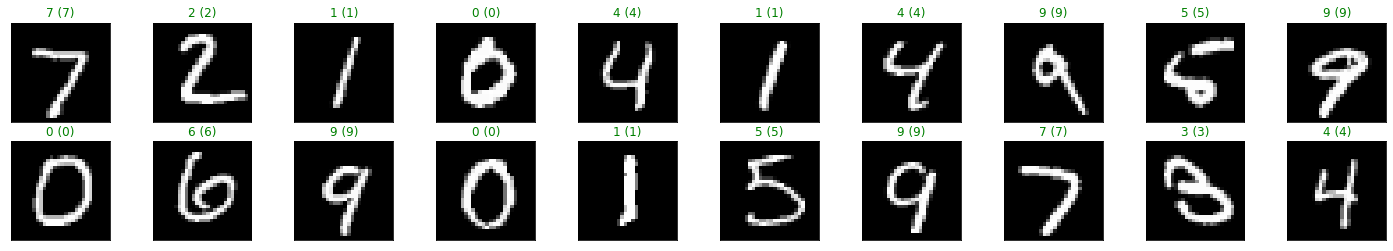

In [15]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

以上就是一个简单的early-stoping的策略。